# Set-up

In [81]:
import pandas as pd
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import plotly.express as px
import seaborn as sns
import numpy as np
import random
from tqdm.notebook import tqdm, trange

sns.set_theme()
colors = sns.color_palette("deep")

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances_argmin
from utils import geometric_median, geometric_medoid
from math import floor, ceil, sqrt
from NMF_iter import functional_norm, normalize_curves
from scipy.stats import levene

from itertools import permutations

In [2]:
def plot_components(H, ax=None, figsize=(10, 6), title='Components found by the NMF', component_names=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = ax.get_figure()

    n_components = H.shape[0]
    for k in range(n_components):
        if component_names is not None:
            label = component_names[k]
        else:
            label = f'Component {k + 1}'
        ax.plot(H[k, :], marker='o', linestyle='-', label=label)

    ax.set_xlabel('Hour')
    ax.set_ylabel('Load (MW)')
    ax.set_title(title)
    ax.legend()
    
    return fig, ax

In [3]:
def plot_components(H_dict, nrows=None, ncols=None, figsize=(20, 10)):
    if nrows is None and ncols is None:
        nrows = floor(sqrt(len(H_dict)))
        ncols = ceil(len(H_dict) / nrows)
    fig, axs = plt.subplots(nrows, ncols, figsize=figsize, squeeze=False, sharey=True)

    for idx, (method, H) in enumerate(H_dict.items()):
        i = idx // ncols
        j = idx % ncols
        
        abscissa = np.linspace(0, 24, H.shape[1])
        for k in range(H.shape[0]):
            label = f'Component {k + 1}'
            if 'smoothed' in method:
                marker=None
            else:
                marker = 'o'
            axs[i,j].plot(abscissa, H[k, :], marker=marker, linestyle='-', label=label)
        
        axs[i,j].set_xlabel('Hour')
        # axs[i,j].set_ylabel('Normalized Load')
        axs[i,j].set_title(method)
        axs[i,j].legend()
    plt.subplots_adjust(wspace=0.05)
    return fig, axs

In [4]:
def plot_residual_curves(residuals_dict, n_curves_plotted=10, nrows=None, ncols=None, figsize=(20, 10), **kwargs):
    if nrows is None and ncols is None:
        nrows = floor(sqrt(len(residuals_dict)))
        ncols = ceil(len(residuals_dict) / nrows)
    fig, axs = plt.subplots(nrows, ncols, figsize=figsize, squeeze=False, sharey=True)

    curves_to_plot = random.sample(range(next(iter(residuals_dict.values())).shape[0]), n_curves_plotted)

    for idx, (method, resid) in enumerate(residuals_dict.items()):
        i = idx // ncols
        j = idx % ncols
        
        for n in curves_to_plot:
            axs[i,j].plot(resid.iloc[n, :], marker='o', linestyle='-', **kwargs)
        
        axs[i,j].set_xlabel('Hour')
        # axs[i,j].set_ylabel('Normalized Load')
        axs[i,j].set_title(method)
        # axs[i,j].legend()
    plt.subplots_adjust(wspace=0.05)
    return fig, axs

In [5]:
def plot_residual_boxplots(residuals_with_info, nrows=None, ncols=None, figsize=(20, 10), rotate_xlabels=False, **kwargs):
    nrows = floor(sqrt(len(residuals_with_info)))
    ncols = ceil(len(residuals_with_info) / nrows)

    fig, axs = plt.subplots(nrows, ncols, figsize=figsize, sharex=True, sharey=True)

    for idx, (method, resid_df)  in enumerate(residuals_with_info.items()):
        i = idx // ncols
        j = idx % ncols
        sns.boxplot(
            resid_df,
            y='residual',
            ax=axs[i, j],
            **kwargs
        )
        axs[i, j].set_title(method)
        if rotate_xlabels:
            axs[i, j].tick_params(axis='x', rotation=45)
    plt.subplots_adjust(wspace=0.05)
    return fig, axs

In [6]:
def plot_random_reconstructed(reconstructed, X, n_obs=4, override_methods=None, figsize=(20,10), **kwargs):
    nrows = floor(sqrt(n_obs))
    ncols = ceil(n_obs / nrows)

    fig, axs = plt.subplots(nrows, ncols, figsize=figsize, sharex=True, sharey=True)
    
    first_element = next(iter(reconstructed.values()))
    random_curves_idx = random.sample(first_element.index.to_list(), n_obs)

    for idx, name in enumerate(random_curves_idx):
        i = idx // ncols
        j = idx % ncols
        for method, recons in reconstructed.items():
            if override_methods:
                if method in override_methods:
                    axs[i,j].plot(recons.loc[name], marker='o', linestyle='-', label=method, **kwargs)
            else:
                axs[i,j].plot(recons.loc[name], marker='o', linestyle='-', label=method, **kwargs)
        axs[i,j].plot(X.loc[name], marker='o', linestyle='-', label='True curve', **kwargs)
        axs[i,j].set_xlabel('Hour')
        axs[i,j].set_title(name)
        axs[i,j].legend()
    plt.subplots_adjust(wspace=0.05)
    return fig, axs

In [7]:
info_cols = ['region', 'year', 'month', 'daytype']

def plot_concentrations_boxplots(W_with_info, nrows=None, ncols=None, figsize=(20, 10), rotate_xlabels=False, title=None, replicate_legend=True, **kwargs):
    nrows = floor(sqrt(len(W_with_info)))
    ncols = ceil(len(W_with_info) / nrows)

    fig, axs = plt.subplots(nrows, ncols, figsize=figsize, sharex=True, sharey=True)

    for idx, (method, W_df)  in enumerate(W_with_info.items()):
        i = idx // ncols
        j = idx % ncols
        sns.boxplot(
            W_df.melt(id_vars=info_cols, var_name='component', value_name='concentration'),
            y='concentration',
            ax=axs[i, j],
            **kwargs
        )
        axs[i, j].set_title(method)
        
        if not replicate_legend and idx != 0:
            axs[i, j].get_legend().remove()

        if rotate_xlabels:
            axs[i, j].tick_params(axis='x', rotation=45)
    
    if title:
        fig.suptitle(title, fontsize=16)
    
    plt.subplots_adjust(wspace=0.05)
    return fig, axs

In [9]:
max_n_components = 6
colormap = ListedColormap([colors[k] for k in range(max_n_components)])

# Load results and input data

## NMF Results

In [10]:
method_names = [
    'WHopt_3comp_1000runs',
    'WHopt_3comp_10000runs',
    'WHopt_3comp_smoothed_1000runs',
    'FPCA_3PCs',
    'WHopt_4comp_1000runs',
    'WHopt_4comp_10000runs',
    'WHopt_4comp_smoothed_1000runs',
    'FPCA_4PCs',
]

nmf_method_names = [method for method in method_names if 'PCA' not in method]

W = {}
H = {}

for method in nmf_method_names:
    data = np.load('data/nmf_results/' + method + '.npz', allow_pickle=True)
    W[method] = data['W']
    H[method] = data['H']

In [11]:
# Align the components
ref_H = H['WHopt_3comp_1000runs']

for method in nmf_method_names:

    n_comp = H[method].shape[0]
    ref_n_comp = ref_H.shape[0]
    best_permutation = list(range(n_comp))
    n_eval_points = H[method].shape[1]
    eval_points = np.arange(0, n_eval_points, int(n_eval_points / 24))
    best_alignment = np.linalg.norm(ref_H - H[method][np.ix_(range(ref_n_comp), eval_points)], 'fro')

    for permutation in list(permutations(range(n_comp))):
        alignment = np.linalg.norm(ref_H - H[method][np.ix_(list(permutation)[:ref_n_comp], eval_points)], 'fro')

        if alignment < best_alignment:
            best_alignment = alignment
            best_permutation = list(permutation)

    H[method] = H[method][best_permutation, :]
    W[method] = W[method][:, best_permutation]

In [12]:
# Align 4comp between them
ref_method = 'WHopt_4comp_1000runs'
ref_H = H[ref_method]

for method in [method for method in nmf_method_names if '4comp' in method and method != ref_method]:

    n_comp = H[method].shape[0]
    ref_n_comp = ref_H.shape[0]
    best_permutation = list(range(n_comp))
    n_eval_points = H[method].shape[1]
    eval_points = np.arange(0, n_eval_points, int(n_eval_points / 24))
    best_alignment = np.linalg.norm(ref_H - H[method][np.ix_(range(ref_n_comp), eval_points)], 'fro')

    for permutation in list(permutations(range(n_comp))):
        alignment = np.linalg.norm(ref_H - H[method][np.ix_(list(permutation)[:ref_n_comp], eval_points)], 'fro')

        if alignment < best_alignment:
            best_alignment = alignment
            best_permutation = list(permutation)

    H[method] = H[method][best_permutation, :]
    W[method] = W[method][:, best_permutation]

## Input data

In [47]:
input_df = pd.read_csv('data/daily_curves_fixed.csv', index_col=0)
unit_info = input_df.index.str.extract(r'^(?P<region>[\w.]+)_(?P<year>\d{4})-(?P<month>\d{2})-\d{2}_(?P<daytype>[\w ]+)$').set_index(input_df.index)
df = pd.concat([input_df, unit_info], axis=1)
print(len(df))
df.head(3)

11646


0        1        2        3        4  \
Calabria_2021-01-02_Saturday     552.943  514.861  462.221  448.924  457.576   
Calabria_2021-01-03_Holiday      518.853  457.879  432.200  419.060  393.992   
Calabria_2021-01-04_Working day  540.431  450.024  434.019  432.949  435.210   

                                       5        6        7        8        9  \
Calabria_2021-01-02_Saturday     462.207  492.594  526.408  579.682  648.228   
Calabria_2021-01-03_Holiday      438.706  462.433  488.501  532.412  641.866   
Calabria_2021-01-04_Working day  457.071  516.980  625.155  691.067  885.798   

                                 ...       19       20       21       22  \
Calabria_2021-01-02_Saturday     ...  828.180  831.509  758.732  669.630   
Calabria_2021-01-03_Holiday      ...  819.056  825.176  754.773  706.062   
Calabria_2021-01-04_Working day  ...  980.735  926.445  845.014  756.975   

                                      23       24    region  year  month  \
Calabria_2021-01-02_Saturday     596.548  518.853  Calabria  2021     01   
Calabria_2021-01-03_Holiday      629.708  540.431  Calabria  2021     01   
Calabria_2021-01-04_Working day  688.183  601.762  Calabria  2021     01   

                                     daytype  
Calabria_2021-01-02_Saturday        Saturday  
Calabria_2021-01-03_Holiday          Holiday  
Calabria_2021-01-04_Working day  Working day  

[3 rows x 29 columns]

In [14]:
X = df.drop(unit_info.columns, axis=1)
# We want to keep a functional l1 norm of 1. In case of 15min interval load measures (so 97 measures), we normalise by the l1 norm of the vector divided by int(97 / 24) = 4
X = normalize_curves(X)
X.head()

0         1         2         3  \
Calabria_2021-01-02_Saturday     0.036819  0.034283  0.030778  0.029892   
Calabria_2021-01-03_Holiday      0.034625  0.030556  0.028842  0.027966   
Calabria_2021-01-04_Working day  0.030835  0.025677  0.024763  0.024702   
Calabria_2021-01-05_Working day  0.034956  0.031889  0.030023  0.029715   
Calabria_2021-01-06_Holiday      0.033561  0.029616  0.028412  0.028415   

                                        4         5         6         7  \
Calabria_2021-01-02_Saturday     0.030469  0.030777  0.032800  0.035052   
Calabria_2021-01-03_Holiday      0.026293  0.029277  0.030860  0.032600   
Calabria_2021-01-04_Working day  0.024831  0.026079  0.029497  0.035669   
Calabria_2021-01-05_Working day  0.028913  0.030107  0.033811  0.039218   
Calabria_2021-01-06_Holiday      0.027903  0.028700  0.029924  0.032797   

                                        8         9  ...        15        16  \
Calabria_2021-01-02_Saturday     0.038599  0.043163  ...  0.043207  0.043862   
Calabria_2021-01-03_Holiday      0.035530  0.042834  ...  0.045282  0.044483   
Calabria_2021-01-04_Working day  0.039430  0.050540  ...  0.048232  0.045538   
Calabria_2021-01-05_Working day  0.043283  0.053841  ...  0.046168  0.044271   
Calabria_2021-01-06_Holiday      0.035796  0.046258  ...  0.046951  0.044372   

                                       17        18        19        20  \
Calabria_2021-01-02_Saturday     0.049662  0.051500  0.055146  0.055368   
Calabria_2021-01-03_Holiday      0.048738  0.050998  0.054659  0.055067   
Calabria_2021-01-04_Working day  0.049652  0.050852  0.055957  0.052859   
Calabria_2021-01-05_Working day  0.047506  0.051417  0.051633  0.050358   
Calabria_2021-01-06_Holiday      0.047203  0.051273  0.052255  0.050949   

                                       21        22        23        24  
Calabria_2021-01-02_Saturday     0.050522  0.044589  0.039722  0.034549  
Calabria_2021-01-03_Holiday      0.050369  0.047118  0.042023  0.036065  
Calabria_2021-01-04_Working day  0.048213  0.043190  0.039265  0.034334  
Calabria_2021-01-05_Working day  0.046345  0.040047  0.035615  0.030337  
Calabria_2021-01-06_Holiday      0.048430  0.044395  0.040193  0.035674  

[5 rows x 25 columns]

## PCA-reconstructed signal

In [15]:
n_pcs = [3, 4]
X_fpca = {}

for k in n_pcs:
    X_fpca[f'FPCA_{k}PCs'] = pd.read_csv(f'data/daily_curves_reconstructed_{k}PCs.csv', index_col=0)
    X_fpca[f'FPCA_{k}PCs'].columns = pd.to_numeric(X_fpca[f'FPCA_{k}PCs'].columns)

# Compare profiles found

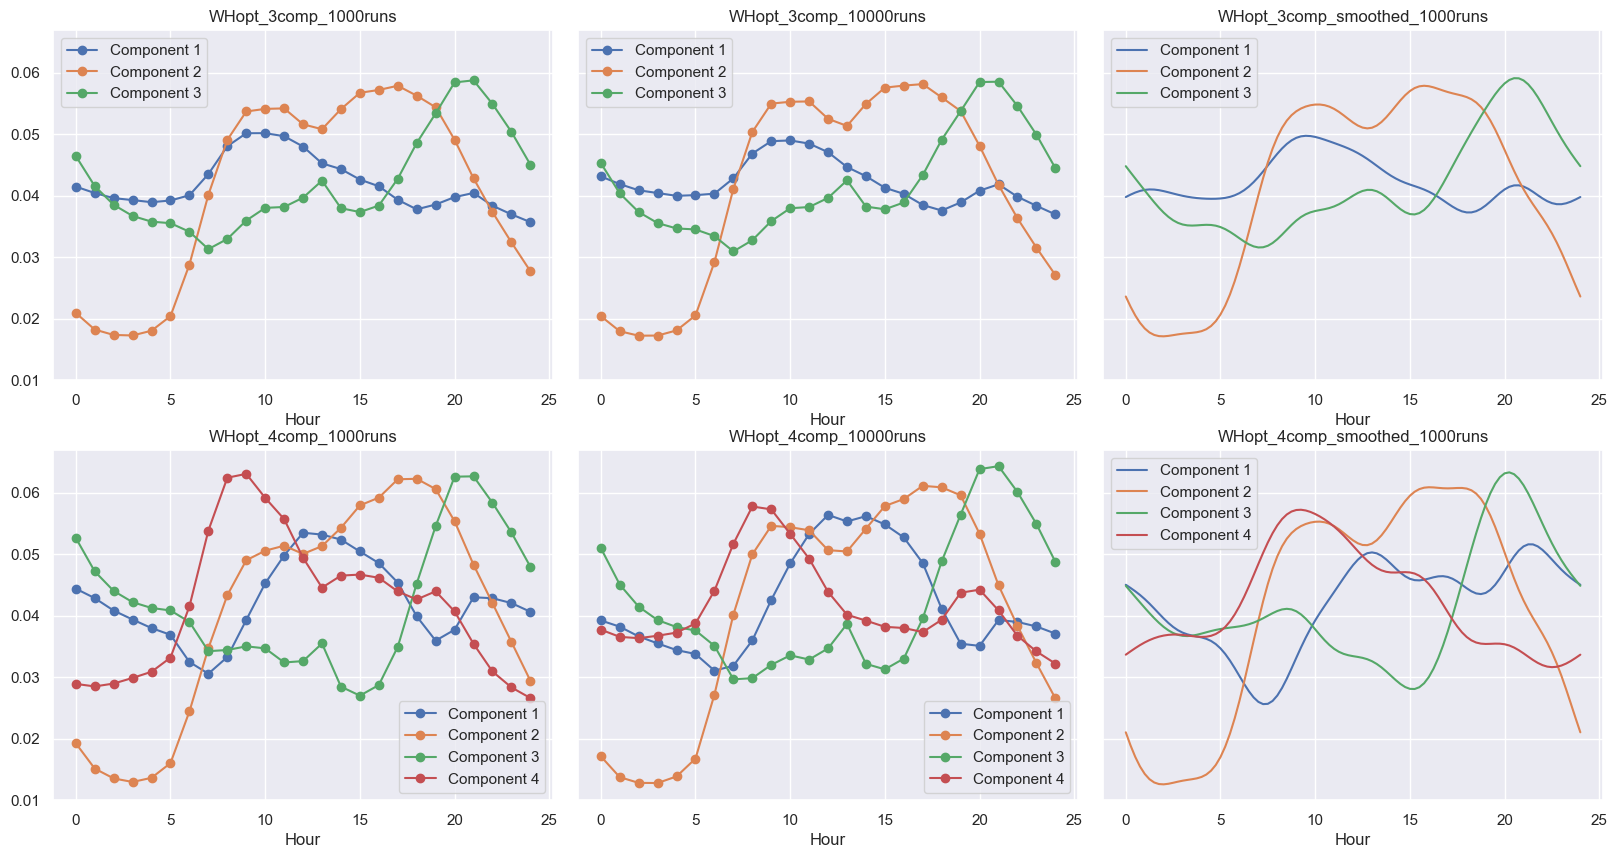

In [19]:
fig, axs = plot_components(H, nrows=2, ncols=3, figsize=(20, 10))

# Assess assumptions on the residuals

In [20]:
reconstructed = {}
residuals = {}

for method in method_names:
    if method not in nmf_method_names:
        reconstructed[method] = X_fpca[method]
    else:
        reconstructed_smooth = np.dot(W[method], H[method])
        n_eval_points = H[method].shape[1]
        reconstructed[method] = pd.DataFrame(reconstructed_smooth[:, np.arange(0, n_eval_points, int(n_eval_points / 24))], index=input_df.index)

    residuals[method] = X.values - reconstructed[method]

## Residual curves

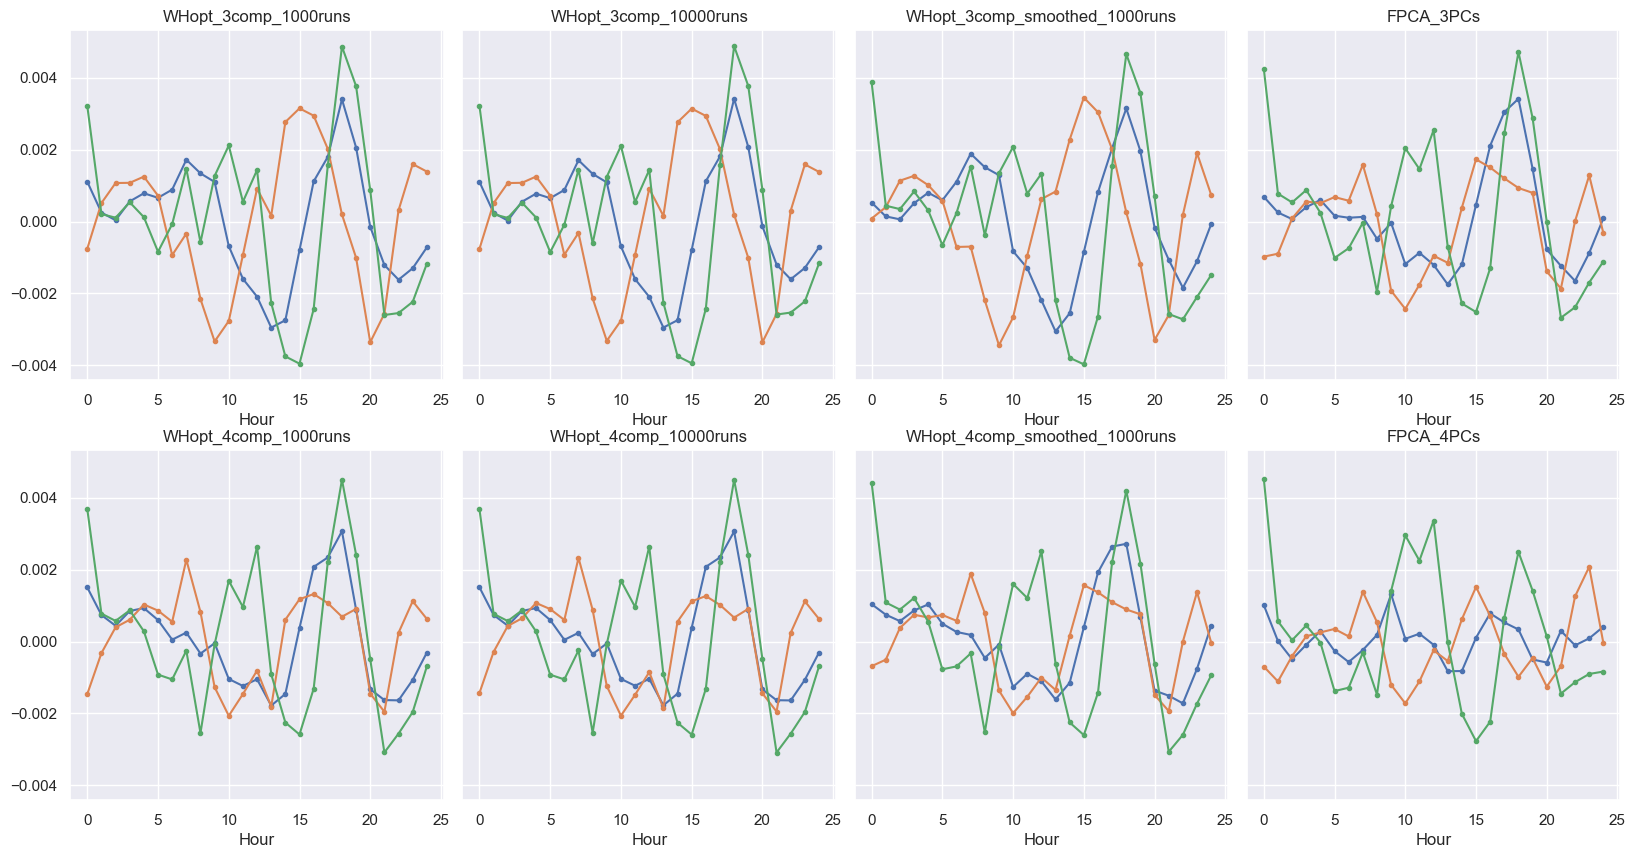

In [21]:
fig, axs = plot_residual_curves(residuals, n_curves_plotted=3, figsize=(20, 10), markersize=3)

## Residual histograms

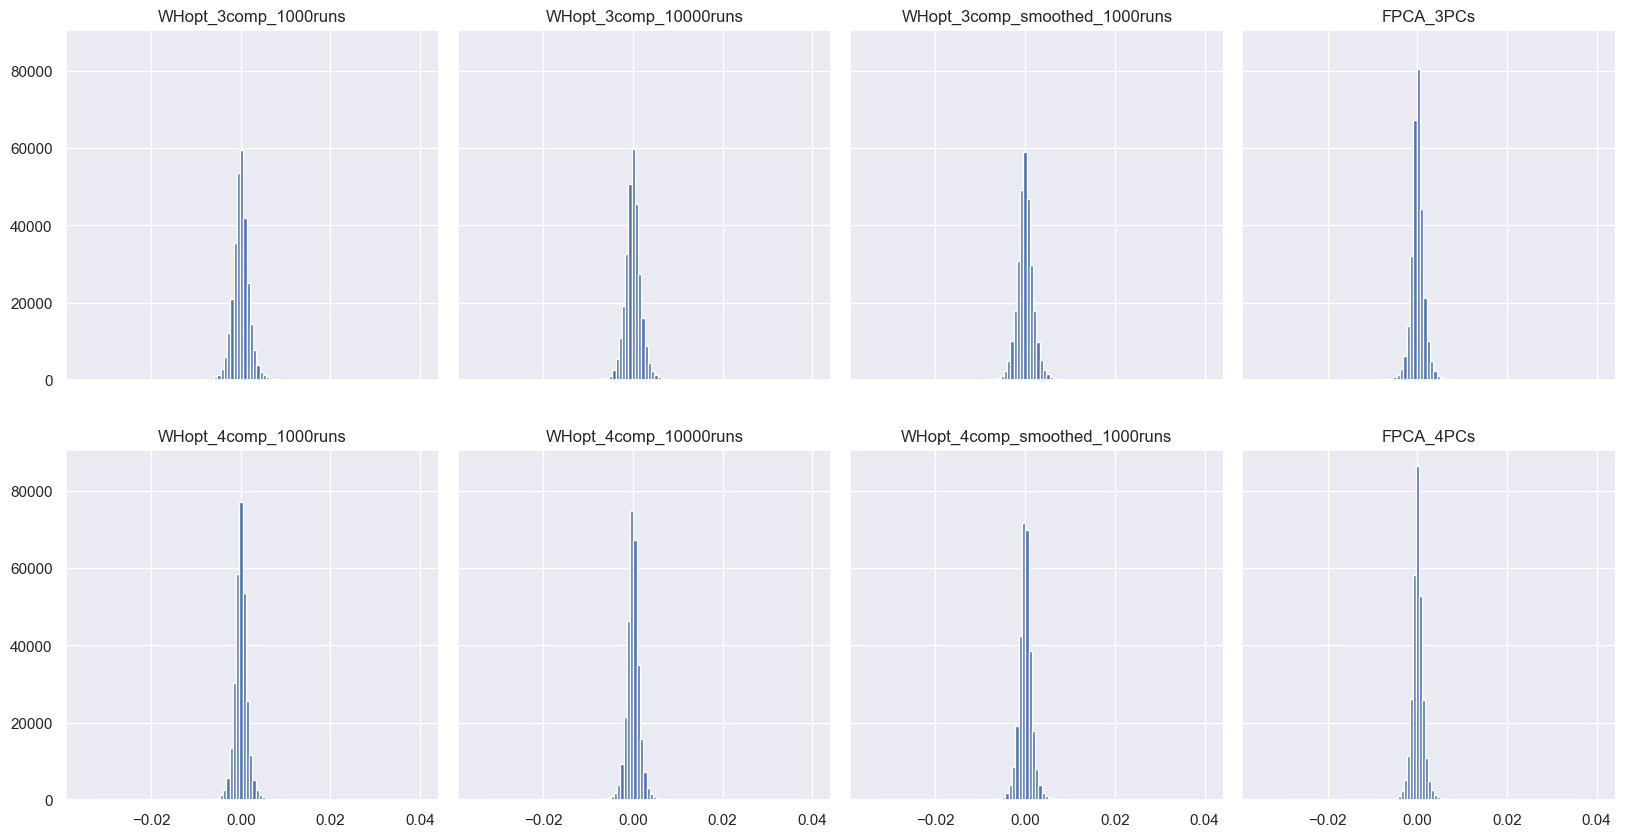

In [22]:
nrows = floor(sqrt(len(method_names)))
ncols = ceil(len(method_names) / nrows)

fig, axs = plt.subplots(nrows, ncols, figsize=(20, 10), sharex=True, sharey=True)

for idx, (method, E)  in enumerate(residuals.items()):
    resid = E.values.flatten()
    i = idx // ncols
    j = idx % ncols
    axs[i, j].hist(resid, bins=100)
    axs[i, j].set_title(method)
plt.subplots_adjust(wspace=0.05)

## Homoschedasticity

In [23]:
residuals_with_info = {}

for method in method_names:
    resid_df = pd.concat([residuals[method], unit_info], axis=1)
    resid_df = resid_df.melt(id_vars=info_cols, var_name='hour', value_name='residual')
    residuals_with_info[method] = resid_df

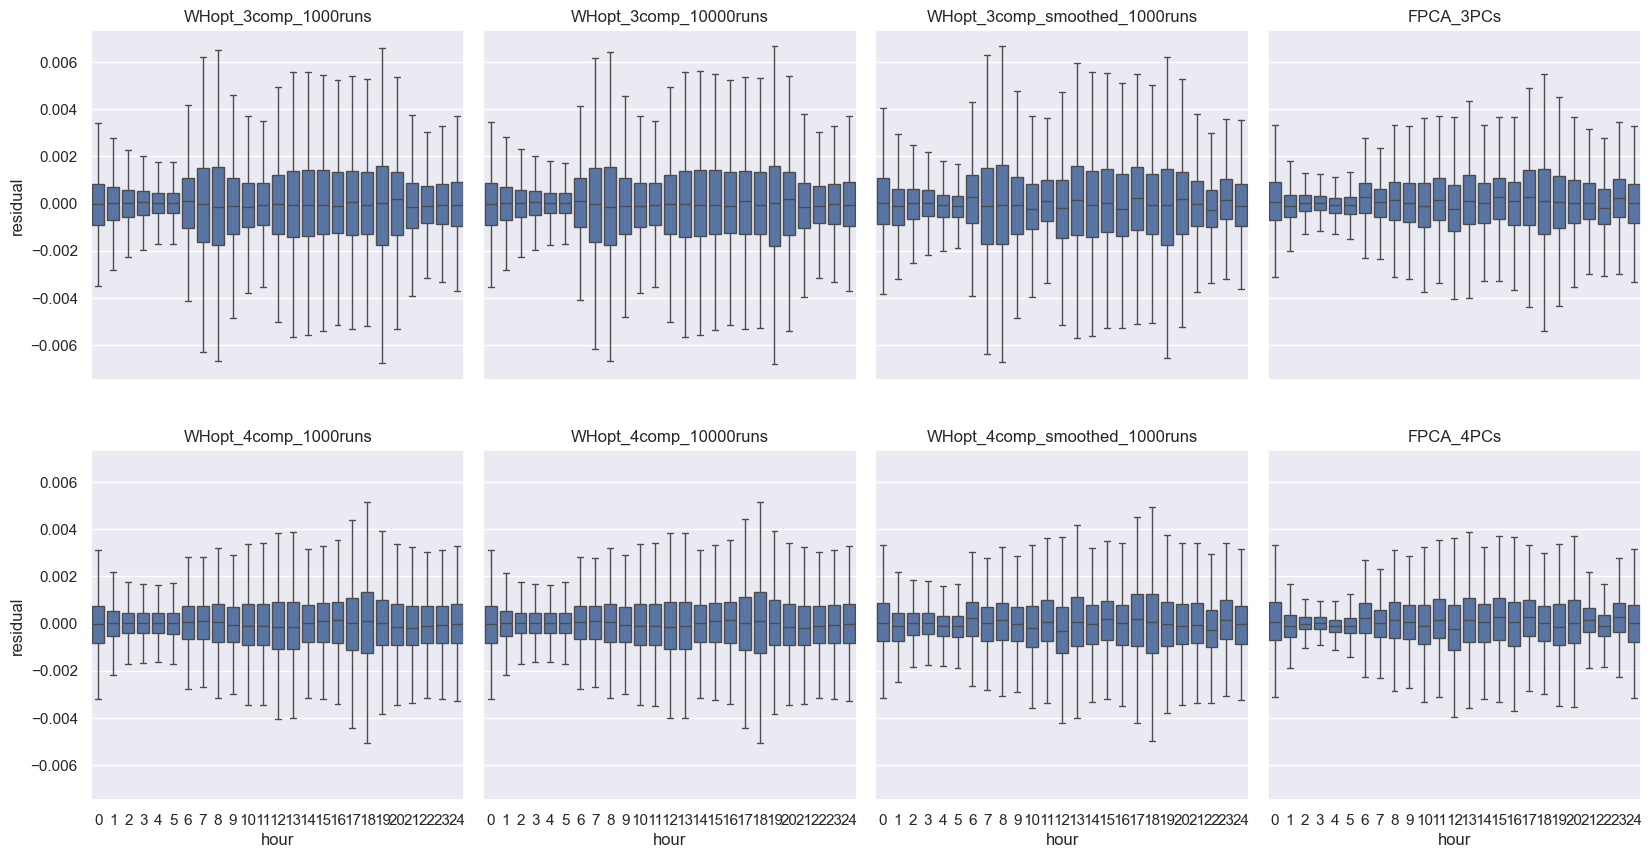

In [24]:
fig, axs = plot_residual_boxplots(residuals_with_info, x='hour', showfliers=False, figsize=(20,10))

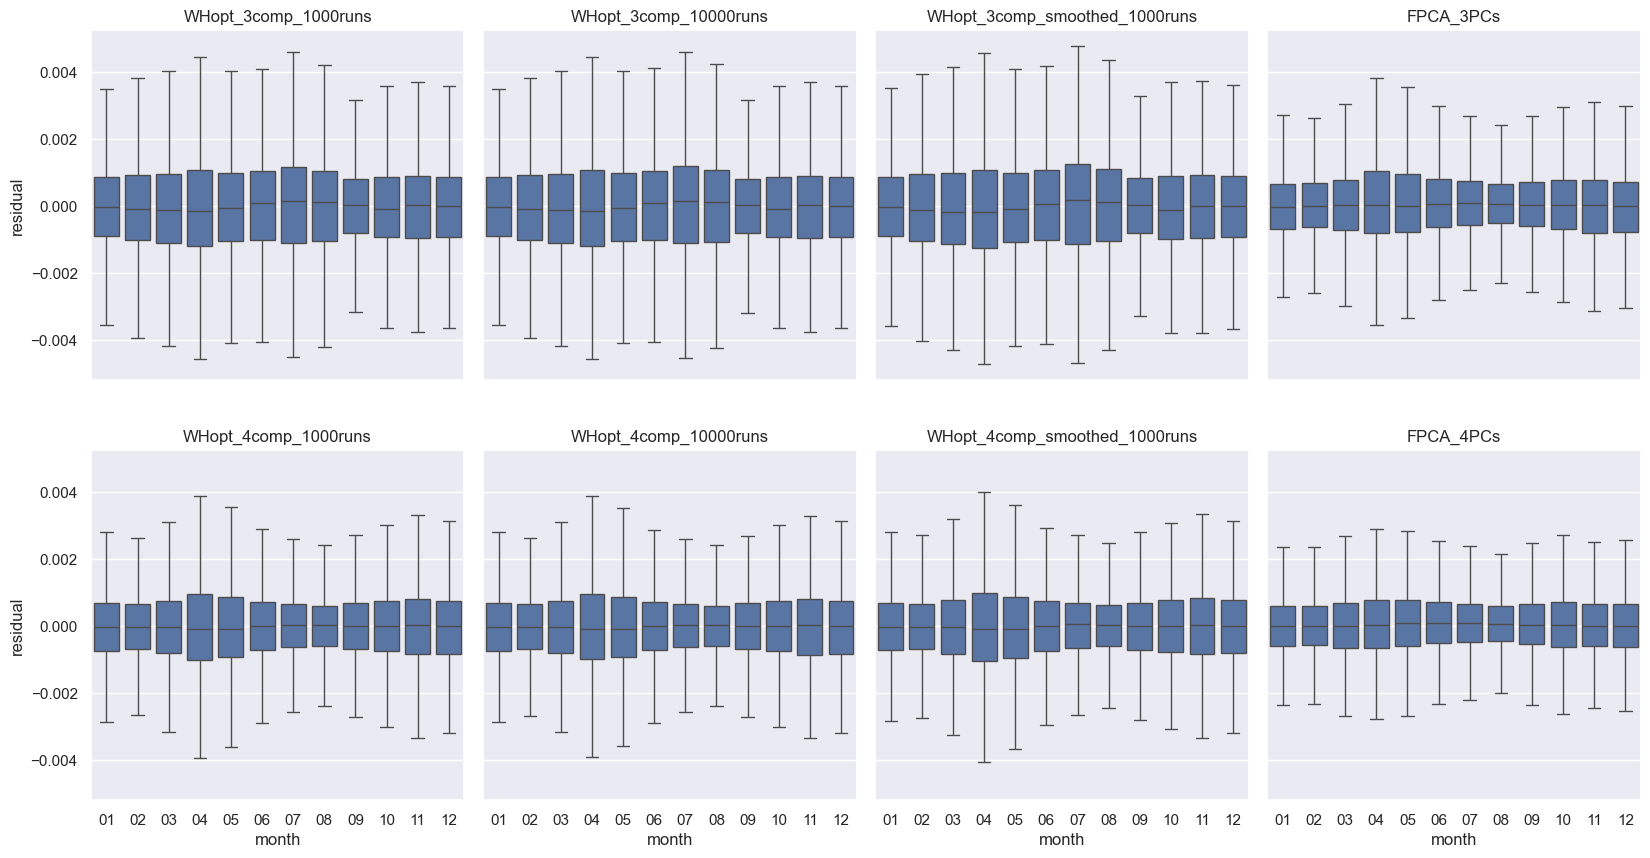

In [25]:
fig, axs = plot_residual_boxplots(residuals_with_info, x='month', showfliers=False)

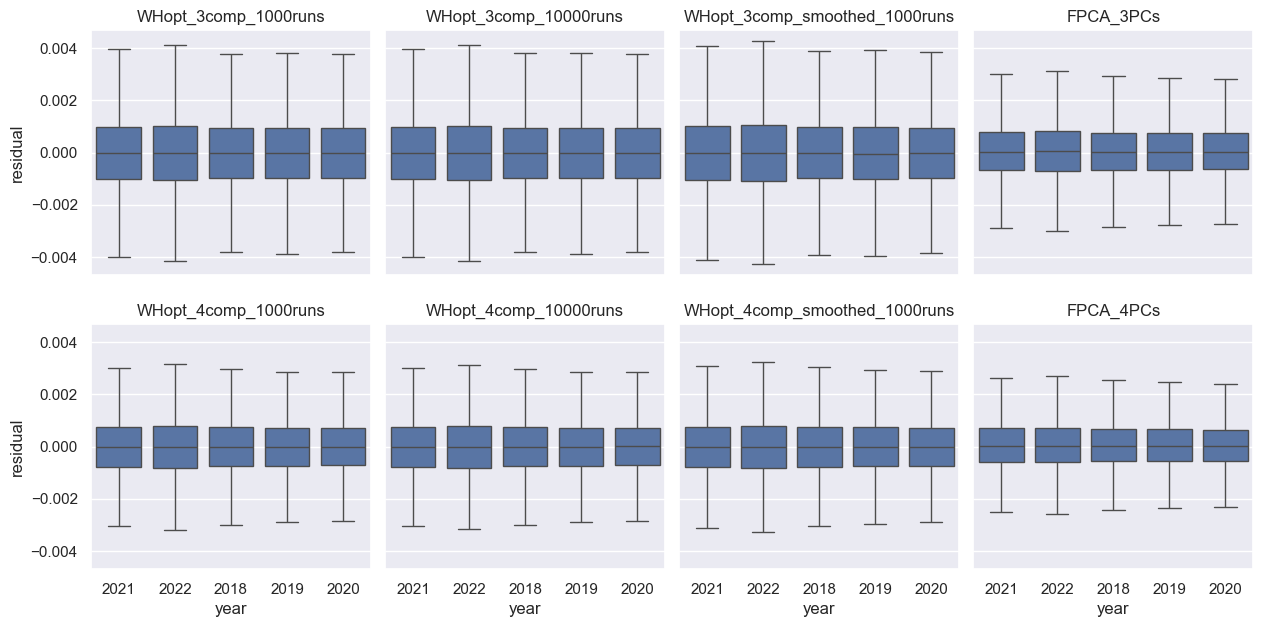

In [26]:
fig, axs = plot_residual_boxplots(residuals_with_info, x='year', showfliers=False, figsize=(15,7))

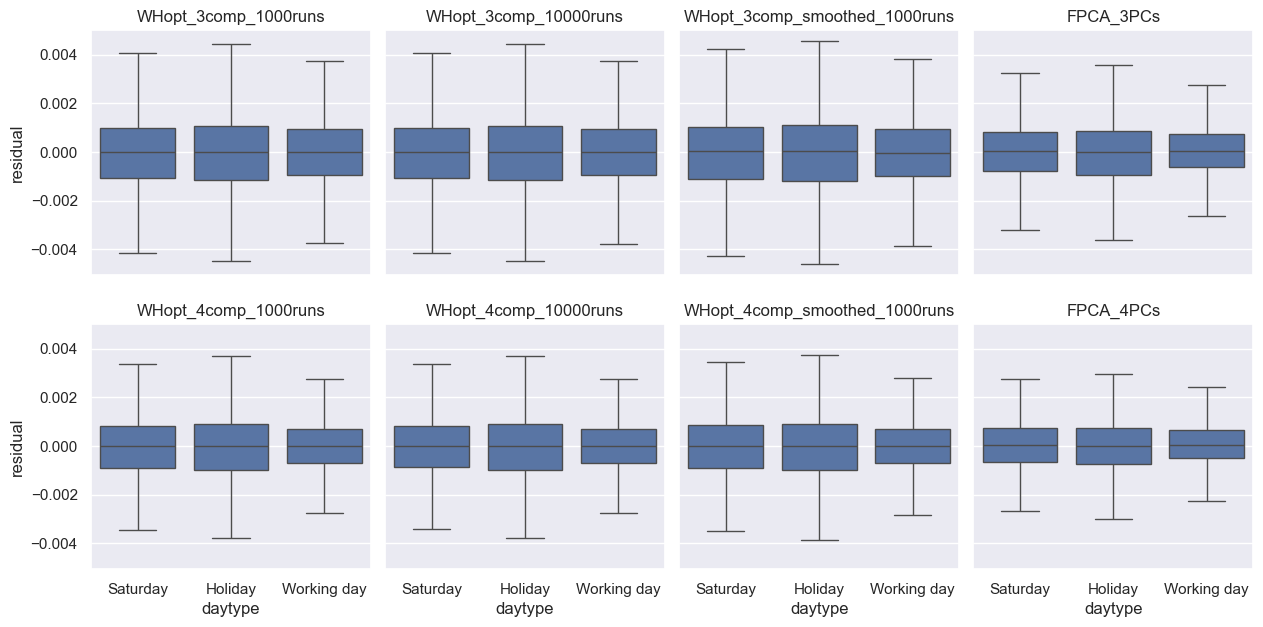

In [27]:
fig, axs = plot_residual_boxplots(residuals_with_info, x='daytype', showfliers=False, figsize=(15,7))

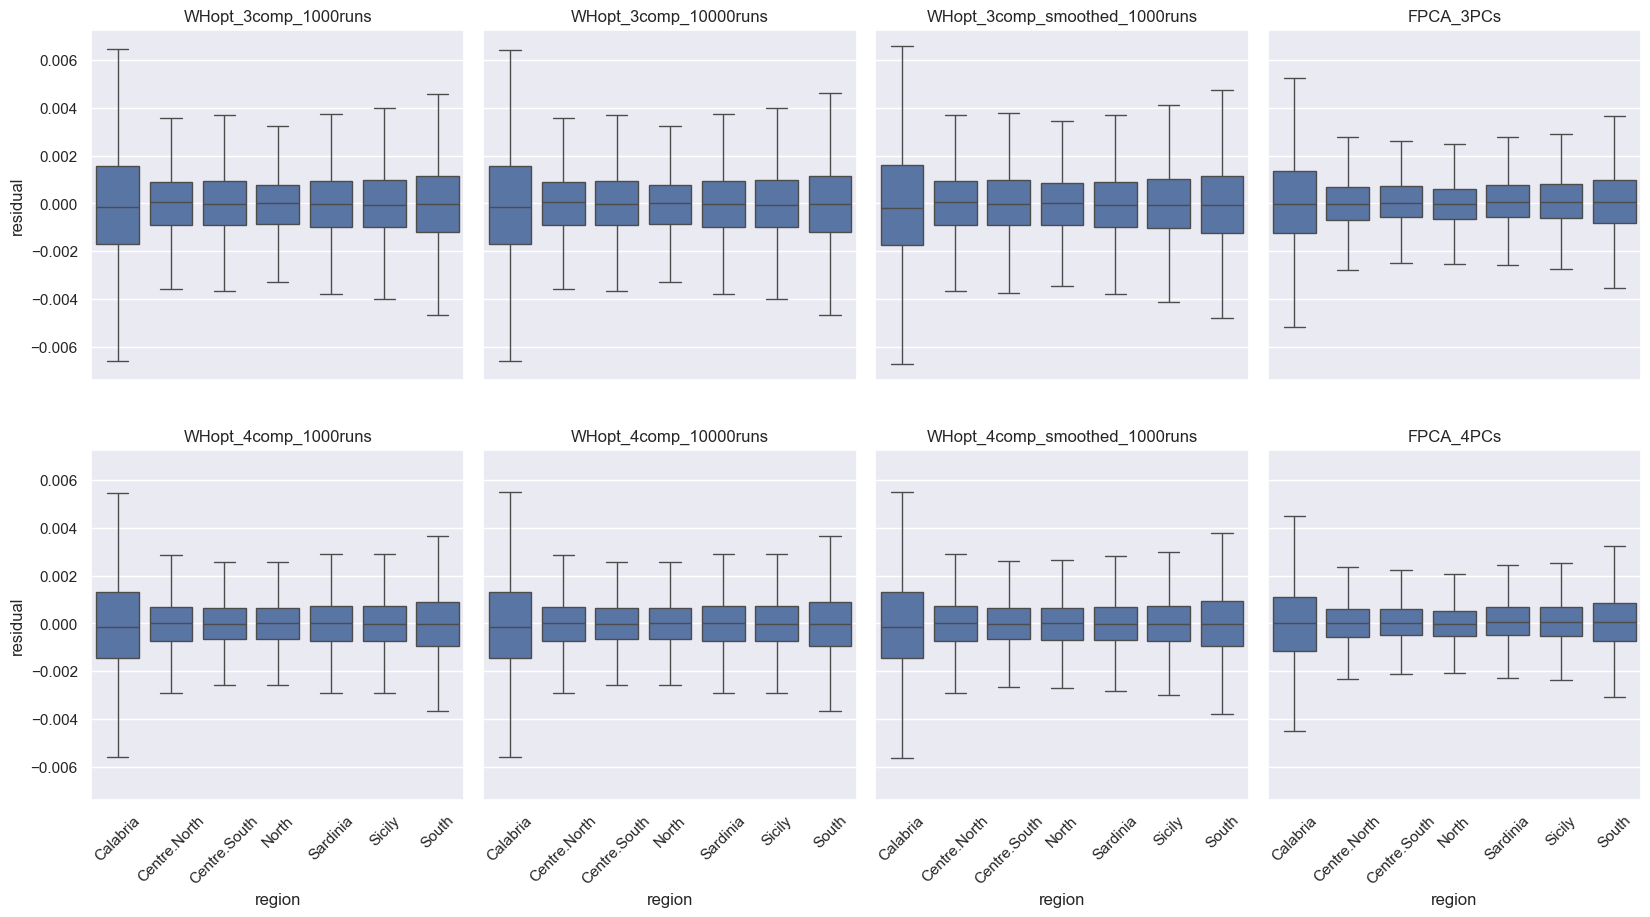

In [28]:
fig, axs = plot_residual_boxplots(residuals_with_info, x='region', showfliers=False, rotate_xlabels=True)

# Compare model fit

In [29]:
print(method_names)

['WHopt_3comp_1000runs', 'WHopt_3comp_10000runs', 'WHopt_3comp_smoothed_1000runs', 'FPCA_3PCs', 'WHopt_4comp_1000runs', 'WHopt_4comp_10000runs', 'WHopt_4comp_smoothed_1000runs', 'FPCA_4PCs']


In [32]:
# Sample data for groups
method1 = 'FPCA_3PCs'
method2 = 'WHopt_4comp_smoothed_1000runs'

# Performing Levene's test
res1 = residuals_with_info[method1]['residual']
res2 = residuals_with_info[method2]['residual']
statistic, p_value = levene(res1, res2)

# Print estimated variance
print("Sum of squared residuals for {} is {:.4f} for {:,} samples".format(method1, (res1**2).sum(), len(res1)))
print("Sum of squared residuals for {} is {:.4f} for {:,} samples".format(method2, (res2**2).sum(), len(res2)))

# Checking the result
print("\nTest Statistic:", statistic)
print("p-value:", p_value)

# Interpretation
if p_value < 0.05:
    print(f"\nReject the null hypothesis")
else:
    print(f"\nFail to reject the null hypothesis")

Sum of squared residuals for FPCA_3PCs is 0.6309 for 291,150 samples
Sum of squared residuals for WHopt_4comp_smoothed_1000runs is 0.6245 for 291,150 samples

Test Statistic: 30.377408985665827
p-value: 3.557960752193853e-08

Reject the null hypothesis


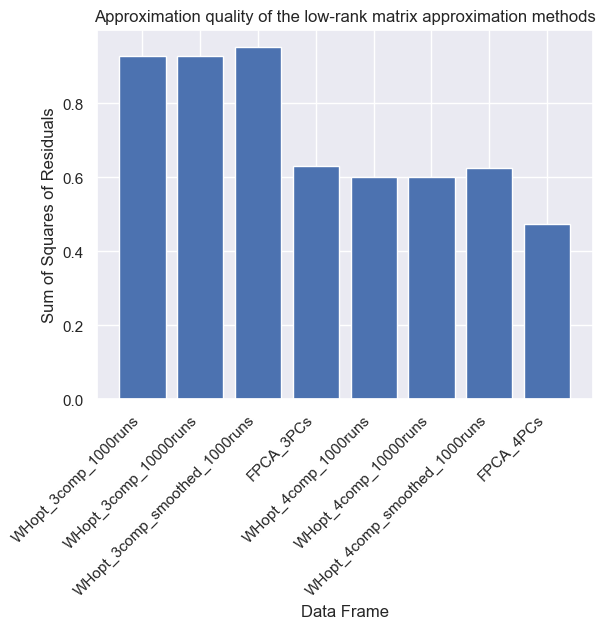

In [31]:
# Initialize lists to store data
labels = []
sums_of_squares = []

# Iterate over the dictionary of data frames
for key, res_df in residuals_with_info.items():
    # Calculate sum of squares of residuals
    sum_of_squares = (res_df['residual'] ** 2).sum()
    
    # Append to lists
    labels.append(key)
    sums_of_squares.append(sum_of_squares)

# Create bar plot
plt.bar(labels, sums_of_squares)
plt.xlabel('Data Frame')
plt.ylabel('Sum of Squares of Residuals')
plt.title('Approximation quality of the low-rank matrix approximation methods')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()

# Showing examples of reconstructed curves

In [33]:
method_names

['WHopt_3comp_1000runs',
 'WHopt_3comp_10000runs',
 'WHopt_3comp_smoothed_1000runs',
 'FPCA_3PCs',
 'WHopt_4comp_1000runs',
 'WHopt_4comp_10000runs',
 'WHopt_4comp_smoothed_1000runs',
 'FPCA_4PCs']

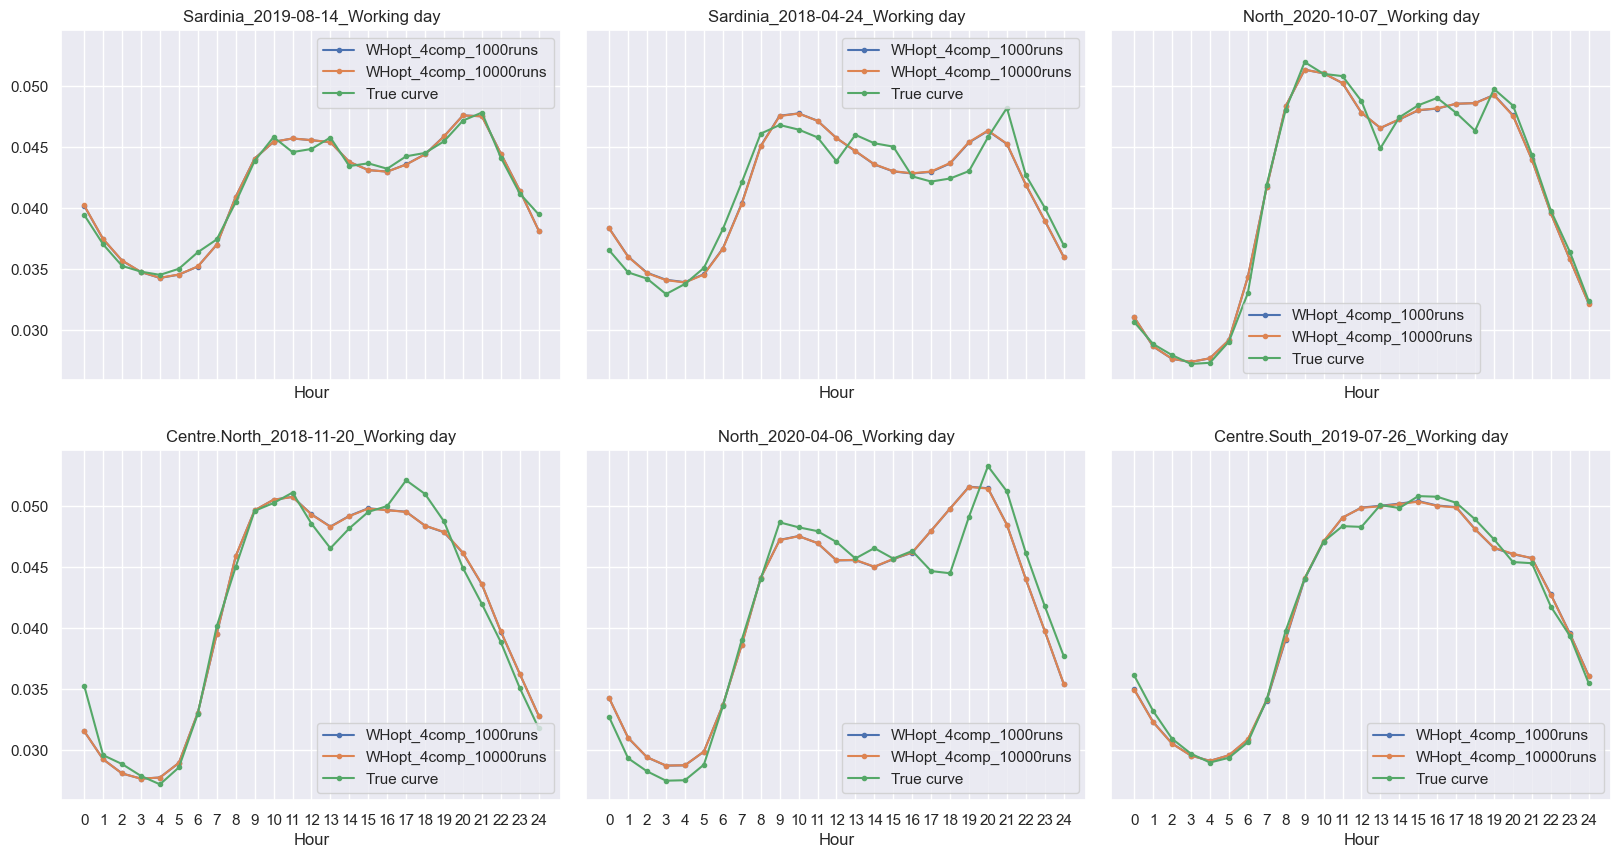

In [40]:
override_methods = ['WHopt_4comp_1000runs', 'WHopt_4comp_10000runs']
fig, ax = plot_random_reconstructed(reconstructed, X, override_methods=override_methods, n_obs=6, figsize=(20,10), markersize=3)

# Analyse concentrations

In [41]:
W_with_info = {}
for method in nmf_method_names:
    W_df = pd.DataFrame(W[method], index=input_df.index, columns=[f"Component {k+1}" for k in range(W[method].shape[1])])
    W_df = pd.concat([W_df, unit_info], axis=1)
    W_with_info[method] = W_df.sort_values(['year', 'month', 'region'])

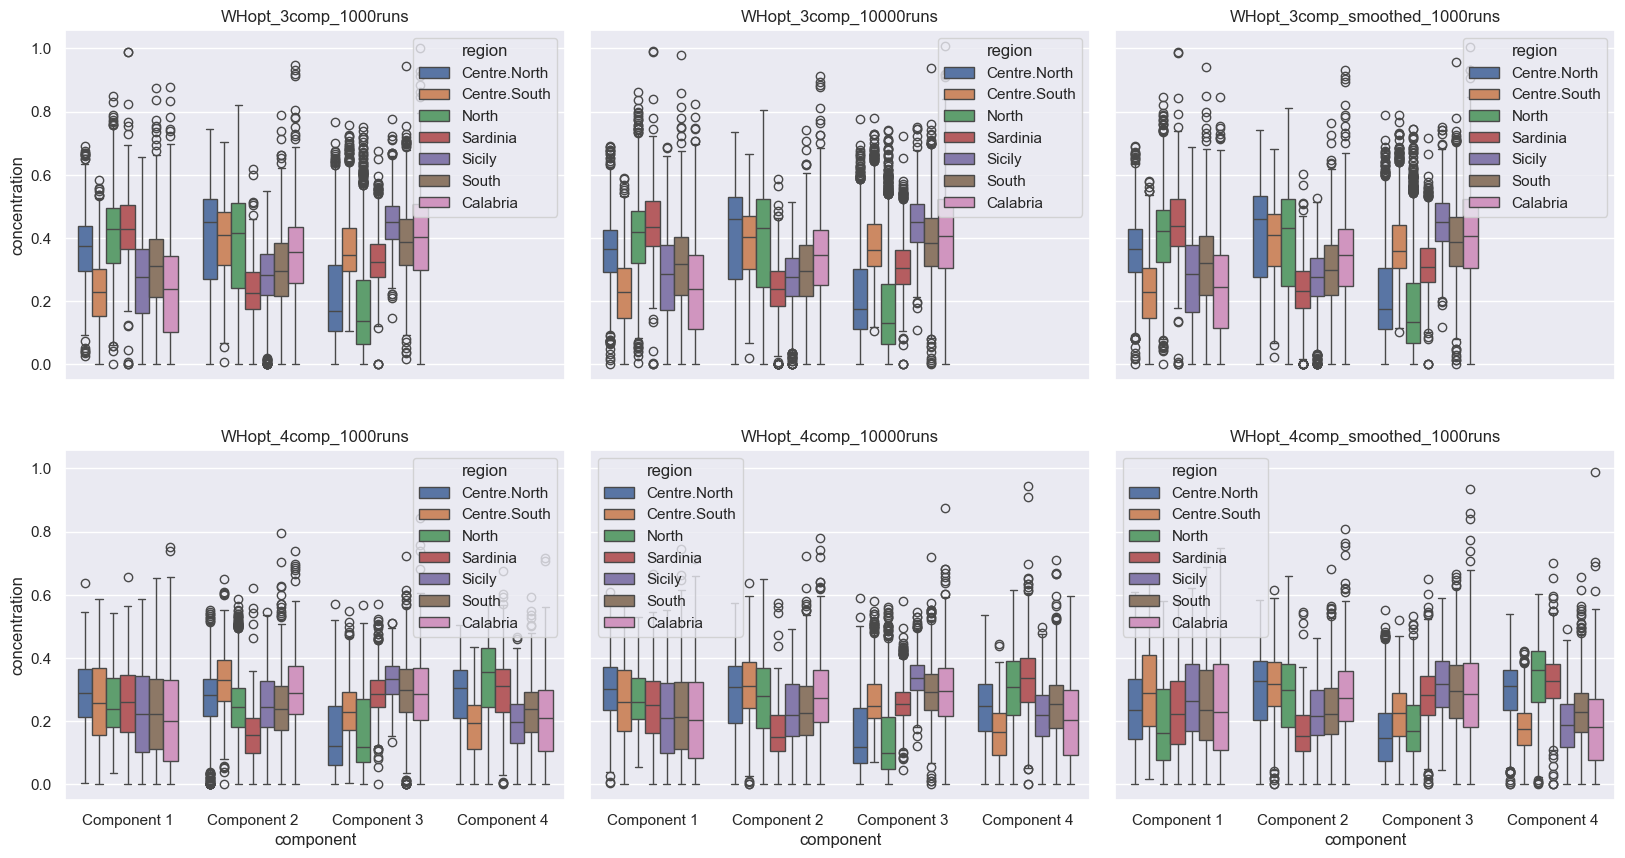

In [42]:
fig, ax = plot_concentrations_boxplots(W_with_info, x='component', hue='region')

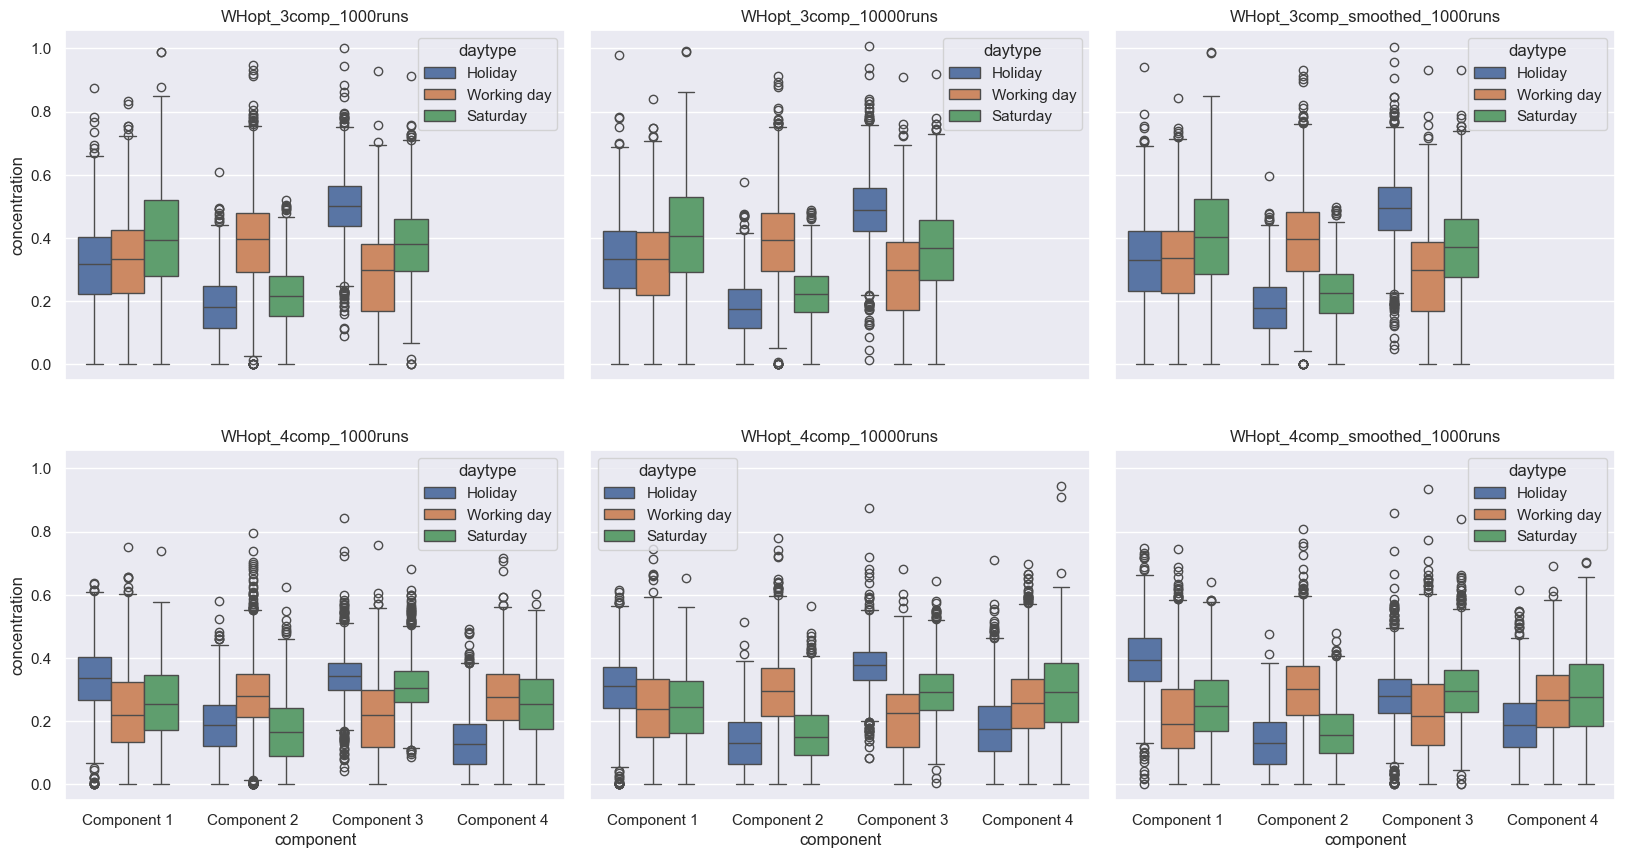

In [43]:
fig, ax = plot_concentrations_boxplots(W_with_info, x='component', hue='daytype')

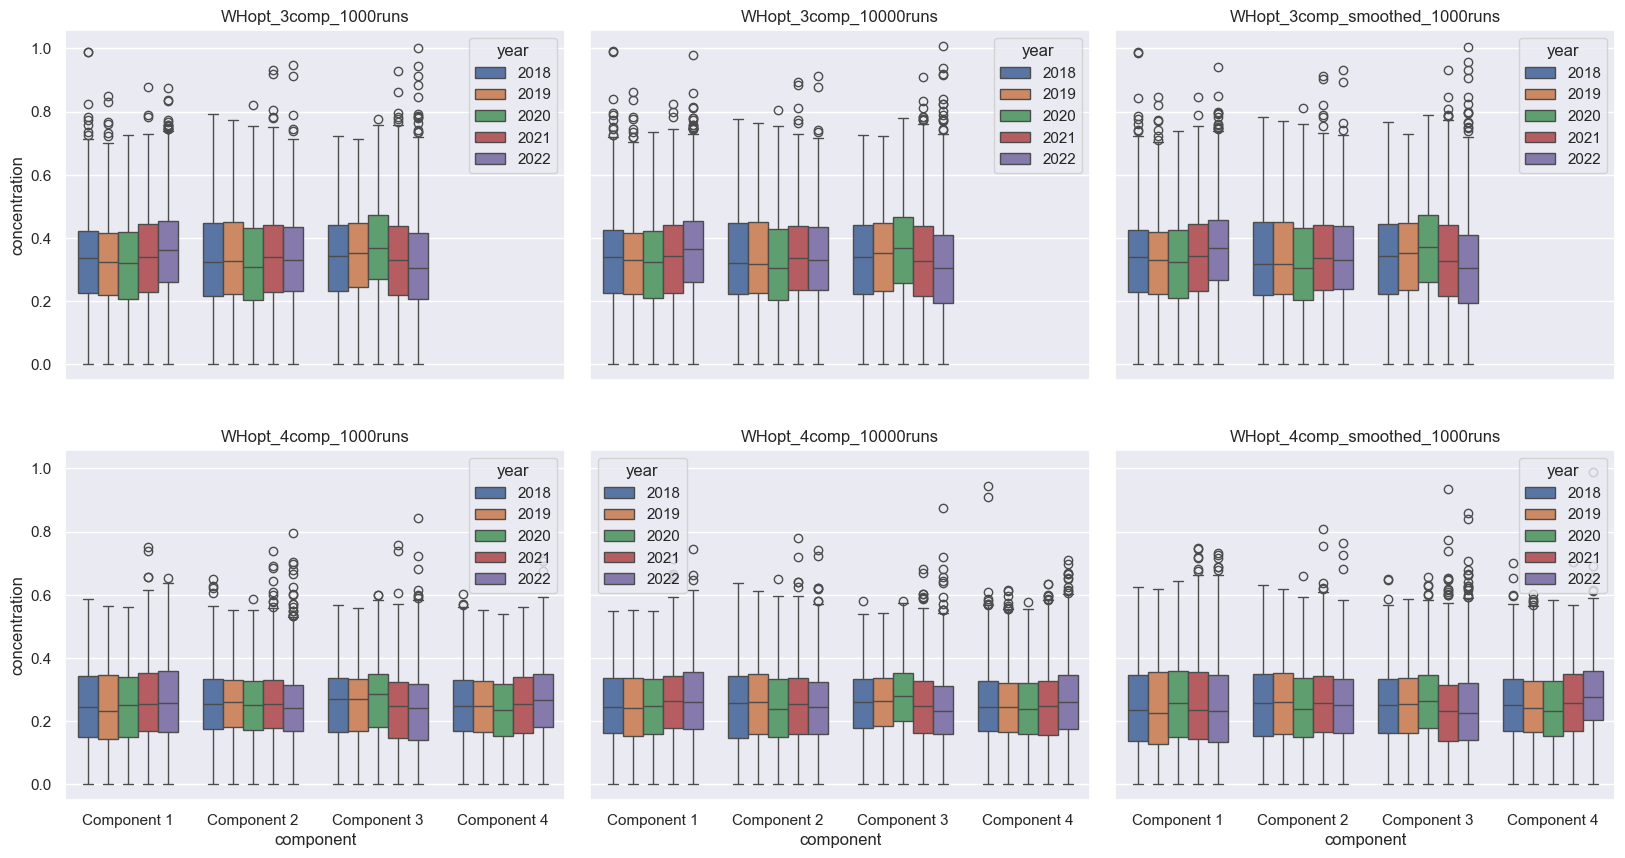

In [44]:
fig, ax = plot_concentrations_boxplots(W_with_info, x='component', hue='year')

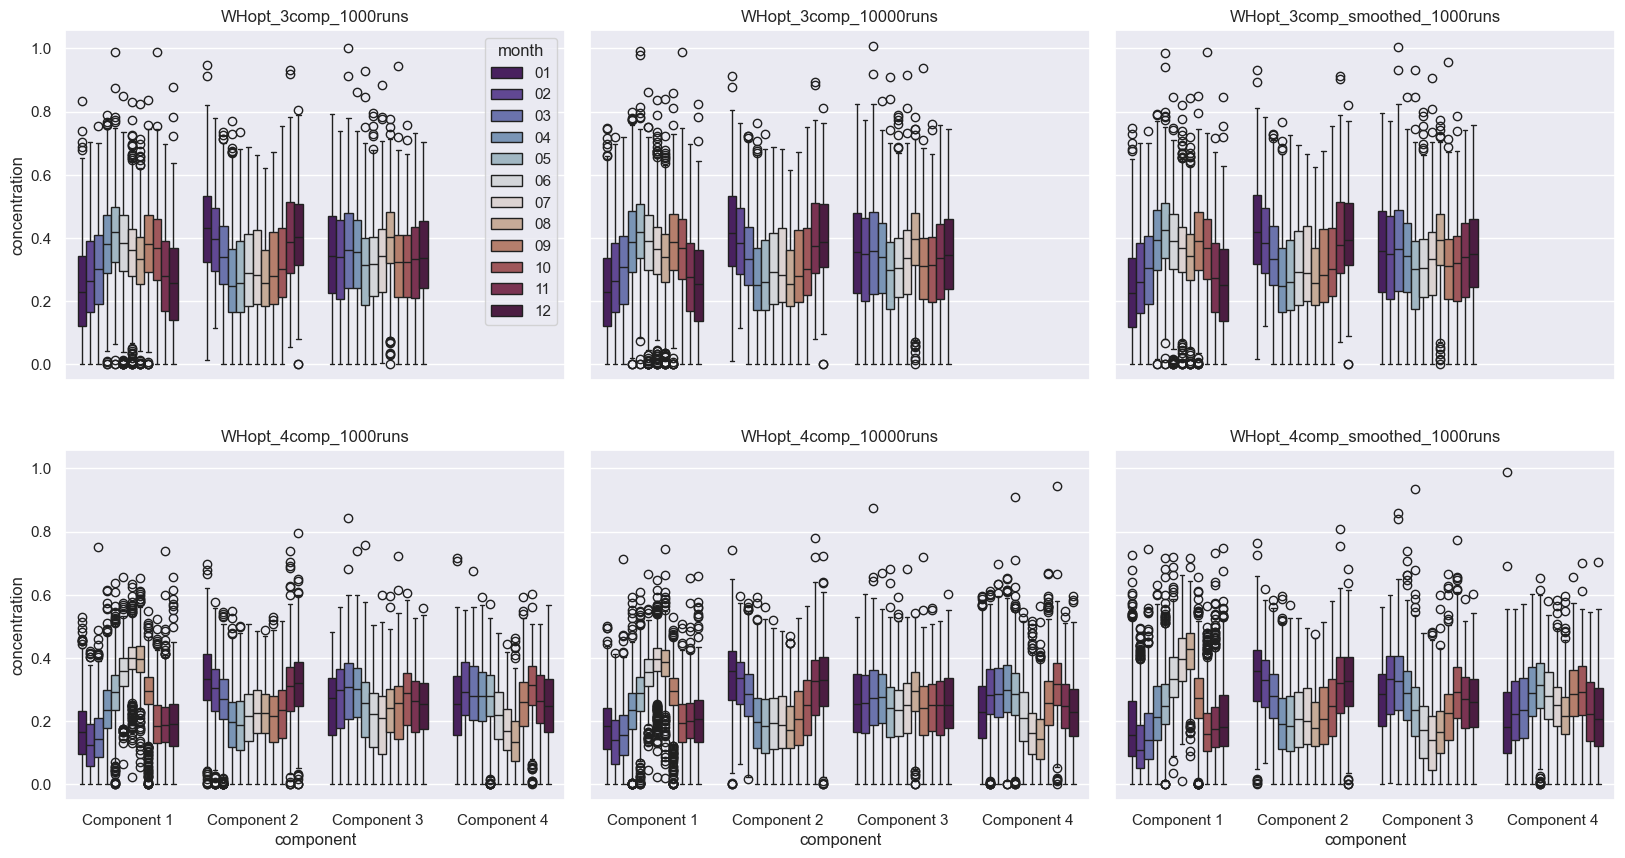

In [45]:
fig, ax = plot_concentrations_boxplots(W_with_info, x='component', hue='month', palette='twilight_shifted', replicate_legend=False)

# Analyse deconvolution of the total load

In [76]:
X_unnorm = df.drop(unit_info.columns, axis=1)
h = 24 / (X_unnorm.shape[1]-1)
norm_X = X_unnorm.apply(lambda row: functional_norm(row, h), axis=1, raw=True)

method = 'WHopt_4comp_10000runs'
curves_comp = {}

for k in range(H[method].shape[0]):

    W_k = W[method][:, k]
    H_k = H[method][k, :]

    curves_k = (norm_X * W_k).values.reshape((len(norm_X), 1)).dot(H_k.reshape((1, H_k.shape[0])))
    # We squeeze the 25th point corresponding to hour 24:00 of day d because it is at the same moment of 00:00 of day d+1 and we want a unique value per time instant
    curves_k = pd.DataFrame(curves_k[:,:-1], columns=range(H_k.shape[0]-1), index=X_unnorm.index)
    curves_k['date'] = curves_k.index.str.split('_').str[1]
    curves_k = pd.concat([curves_k, unit_info], axis=1)

    curves_comp[f'Component {k + 1}'] = curves_k

curves_comp['Component 1']

0           1           2  \
Calabria_2021-01-02_Saturday      88.772058   86.474395   82.887595   
Calabria_2021-01-03_Holiday      136.033683  132.512760  127.016373   
Calabria_2021-01-04_Working day   99.792585   97.209680   93.177601   
Calabria_2021-01-05_Working day   71.224885   69.381390   66.503577   
Calabria_2021-01-06_Holiday      202.311969  197.075583  188.901248   
...                                     ...         ...         ...   
South_2022-12-26_Holiday         133.560653  130.103739  124.707274   
South_2022-12-27_Working day      68.838396   67.056671   64.275283   
South_2022-12-28_Working day     200.965645  195.764106  187.644169   
South_2022-12-29_Working day     392.861194  382.692874  366.819474   
South_2022-12-30_Working day       0.875809    0.853141    0.817754   

                                          3           4           5  \
Calabria_2021-01-02_Saturday      80.319778   77.858651   76.430898   
Calabria_2021-01-03_Holiday      123.081467  119.310054  117.122175   
Calabria_2021-01-04_Working day   90.291003   87.524343   85.919343   
Calabria_2021-01-05_Working day   64.443328   62.468682   61.323147   
Calabria_2021-01-06_Holiday      183.049179  177.440260  174.186404   
...                                     ...         ...         ...   
South_2022-12-26_Holiday         120.843903  117.141053  114.992949   
South_2022-12-27_Working day      62.284065   60.375582   59.268430   
South_2022-12-28_Working day     181.831043  176.259449  173.027247   
South_2022-12-29_Working day     355.455583  344.563856  338.245329   
South_2022-12-30_Working day       0.792420    0.768139    0.754053   

                                          6           7           8  \
Calabria_2021-01-02_Saturday      70.301535   72.099259   81.417449   
Calabria_2021-01-03_Holiday      107.729581  110.484402  124.763531   
Calabria_2021-01-04_Working day   79.029055   81.049957   91.524945   
Calabria_2021-01-05_Working day   56.405347   57.847723   65.324028   
Calabria_2021-01-06_Holiday      160.217552  164.314576  185.550778   
...                                     ...         ...         ...   
South_2022-12-26_Holiday         105.771107  108.475847  122.495388   
South_2022-12-27_Working day      54.515407   55.909455   63.135256   
South_2022-12-28_Working day     159.151354  163.221113  184.315995   
South_2022-12-29_Working day     311.119798  319.075638  360.313334   
South_2022-12-30_Working day       0.693582    0.711318    0.803250   

                                          9  ...          19          20  \
Calabria_2021-01-02_Saturday      96.316506  ...   80.208808   79.411228   
Calabria_2021-01-03_Holiday      147.594741  ...  122.911417  121.689211   
Calabria_2021-01-04_Working day  108.273631  ...   90.166257   89.269663   
Calabria_2021-01-05_Working day   77.278055  ...   64.354293   63.714368   
Calabria_2021-01-06_Holiday      219.505803  ...  182.796278  180.978589   
...                                     ...  ...         ...         ...   
South_2022-12-26_Holiday         144.911537  ...  120.676944  119.476958   
South_2022-12-27_Working day      74.688747  ...   62.198014   61.579529   
South_2022-12-28_Working day     218.045059  ...  181.579825  179.774232   
South_2022-12-29_Working day     426.249184  ...  354.964485  351.434791   
South_2022-12-30_Working day       0.950241  ...    0.791326    0.783457   

                                         21          22          23  \
Calabria_2021-01-02_Saturday      88.929695   88.212784   86.559019   
Calabria_2021-01-03_Holiday      136.275244  135.176654  132.642437   
Calabria_2021-01-04_Working day   99.969791   99.163880   97.304810   
Calabria_2021-01-05_Working day   71.351362   70.776160   69.449287   
Calabria_2021-01-06_Holiday      202.671224  201.037380  197.268441   
...                                     ...         ...         ...   
South_2022-12-26_Holiday         133.797823  132.719205  130.231059   
So

In [83]:
load_comp = {}

for k in range(H[method].shape[0]):
    comp = f'Component {k + 1}'
    load_comp[comp] = curves_comp[comp].melt(id_vars=['date']+info_cols, var_name='hour', value_name='load')

    # Convert 'date' column to datetime format
    load_comp[comp]['date'] = pd.to_datetime(load_comp[comp]['date'])

    # Construct datetime column by adding the hour column as timedelta
    load_comp[comp]['datetime'] = load_comp[comp]['date'] + pd.to_timedelta(load_comp[comp]['hour'], unit='h')
    load_comp[comp].set_index('datetime', inplace=True)
    load_comp[comp].sort_values(['region', 'date', 'hour'], inplace=True)

load_comp['Component 1']

date    region  year month      daytype hour  \
datetime                                                                 
2021-01-02 00:00:00 2021-01-02  Calabria  2021    01     Saturday    0   
2021-01-02 01:00:00 2021-01-02  Calabria  2021    01     Saturday    1   
2021-01-02 02:00:00 2021-01-02  Calabria  2021    01     Saturday    2   
2021-01-02 03:00:00 2021-01-02  Calabria  2021    01     Saturday    3   
2021-01-02 04:00:00 2021-01-02  Calabria  2021    01     Saturday    4   
...                        ...       ...   ...   ...          ...  ...   
2022-12-30 19:00:00 2022-12-30     South  2022    12  Working day   19   
2022-12-30 20:00:00 2022-12-30     South  2022    12  Working day   20   
2022-12-30 21:00:00 2022-12-30     South  2022    12  Working day   21   
2022-12-30 22:00:00 2022-12-30     South  2022    12  Working day   22   
2022-12-30 23:00:00 2022-12-30     South  2022    12  Working day   23   

                          load  
datetime                        
2021-01-02 00:00:00  88.772058  
2021-01-02 01:00:00  86.474395  
2021-01-02 02:00:00  82.887595  
2021-01-02 03:00:00  80.319778  
2021-01-02 04:00:00  77.858651  
...                        ...  
2022-12-30 19:00:00   0.791326  
2022-12-30 20:00:00   0.783457  
2022-12-30 21:00:00   0.877364  
2022-12-30 22:00:00   0.870291  
2022-12-30 23:00:00   0.853976  

[279504 rows x 7 columns]

In [88]:
component = 'Component 3'
region = 'North'
df_plot = load_comp[component]
df_plot = df_plot[df_plot.region == region]

fig = px.line(
    df_plot,
    x = df_plot.index,
    y = 'load',
    #line_group='Bidding zone',
    title = f'Total Load Evolution of {component} for region {region} [MW]',
    height = 1000
)

fig.update_xaxes(title_text='Time')
fig.update_yaxes(title_text='Load')
fig.show()

In [105]:
component = 'Component 1'
region = 'North'
df_plot = load_comp[component]
df_plot = df_plot[df_plot.region == region]

fig = px.bar(
    df_plot.groupby(['region', 'year', 'month'], as_index=False)['load'].sum(),
    x = 'month',
    y = 'load',
    color='year',
    title = f'Total monthly consumption of {component} for region {region} [MWh]',
    height = 500,
    barmode='group'
)

fig.update_xaxes(title_text='Time')
fig.update_yaxes(title_text='Consumption')
fig.show()

In [106]:
component = 'Component 2'
region = 'North'
df_plot = load_comp[component]
df_plot = df_plot[df_plot.region == region]

fig = px.bar(
    df_plot.groupby(['region', 'year', 'month'], as_index=False)['load'].sum(),
    x = 'month',
    y = 'load',
    color='year',
    title = f'Total monthly consumption of {component} for region {region} [MWh]',
    height = 500,
    barmode='group'
)

fig.update_xaxes(title_text='Time')
fig.update_yaxes(title_text='Consumption')
fig.show()

In [107]:
component = 'Component 3'
region = 'North'
df_plot = load_comp[component]
df_plot = df_plot[df_plot.region == region]

fig = px.bar(
    df_plot.groupby(['region', 'year', 'month'], as_index=False)['load'].sum(),
    x = 'month',
    y = 'load',
    color='year',
    title = f'Total monthly consumption of {component} for region {region} [MWh]',
    height = 500,
    barmode='group'
)

fig.update_xaxes(title_text='Time')
fig.update_yaxes(title_text='Consumption')
fig.show()

In [108]:
component = 'Component 4'
region = 'North'
df_plot = load_comp[component]
df_plot = df_plot[df_plot.region == region]

fig = px.bar(
    df_plot.groupby(['region', 'year', 'month'], as_index=False)['load'].sum(),
    x = 'month',
    y = 'load',
    color='year',
    title = f'Total monthly consumption of {component} for region {region} [MWh]',
    height = 500,
    barmode='group'
)

fig.update_xaxes(title_text='Time')
fig.update_yaxes(title_text='Consumption')
fig.show()